In [1]:
import numpy as np
import geopandas as gpd
from models import spatialModelNO2alpha, estimateSpatialAlphas, calcConnectivity, calcReducedConnectivity
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [2]:
data = gpd.read_file('./data/landkreise_no2_14d.json')
dateColNames = data.columns[5:-10]

incubationTime = 7
t_curfew = np.where(dateColNames == '22.03.2020')[0][0]
t_curfew_effect = t_curfew + incubationTime

n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
population = data['population'].values
Ks = population
n0 = n_obs[:, 0]

geometries = data.geometry.values

no2_before = data['obs_no2_mean_before'].values
no2_after = data['obs_no2_mean_after'].values

# optimized parameters
fracSpatial1 = 0.07785674
fracSpatial2 = 0.4297616 
fracNO2Traffic = 0.76424961


spatialModelNO2alpha(fracSpatial1, fracSpatial2, fracNO2Traffic,
    Ks, geometries, t_curfew_effect, t_curfew, n_obs, no2_before, no2_after)

... 1 calls made ...


array([[1.        , 1.38585544, 1.85733259, ...,        nan,        nan,
               nan],
       [1.        , 1.20776   , 1.45206152, ...,        nan,        nan,
               nan],
       [1.        , 1.01068255, 1.02370963, ...,        nan,        nan,
               nan],
       ...,
       [1.        , 1.05944062, 1.13373488, ...,        nan,        nan,
               nan],
       [1.        , 1.1165029 , 1.25574956, ...,        nan,        nan,
               nan],
       [1.        , 1.00496863, 1.01106914, ...,        nan,        nan,
               nan]])

In [3]:
basic_model = pm.Model()

with basic_model:

    fracSpatial1 = pm.Uniform('fracSpatial1', lower=0.01, upper=0.99)
    fracSpatial2 = pm.Uniform('fracSpatial2', lower=0.01, upper=0.99)
    fracNO2Traffic = pm.Uniform('fracNO2Traffic', lower=0.01, upper=0.99)
    sigma = pm.HalfNormal('sigma', sigma=100)

    n_sim = spatialModelNO2alpha(fracSpatial1, fracSpatial2, fracNO2Traffic,
                                Ks, geometries, t_curfew_effect, t_curfew, n_obs, no2_before, no2_after)

    likelihood = pm.Normal('n_obs', mu=n_sim, sigma=sigma, observed=n_obs)

    


AsTensorError: ('Cannot convert [[Elemwise{sqrt,no_inplace}.0]] to TensorType', <class 'numpy.ndarray'>)

In [4]:
mapVals = pm.find_MAP(model=basic_model)
mapVals

logp = -4.7705, ||grad|| = 0.00021916: 100%|██████████| 17/17 [00:00<00:00, 1259.22it/s]


{'fracSpatial1_interval__': array(0.),
 'fracSpatial2_interval__': array(0.),
 'fracNO2Traffic_interval__': array(0.),
 'sigma_log__': array(-1.34059119),
 'fracSpatial1': array(0.5),
 'fracSpatial2': array(0.5),
 'fracNO2Traffic': array(0.5),
 'sigma': array(0.26169091)}

In [5]:
with basic_model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, fracNO2Traffic, fracSpatial2, fracSpatial1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1007.66draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdad825ac18>,
      dtype=object)

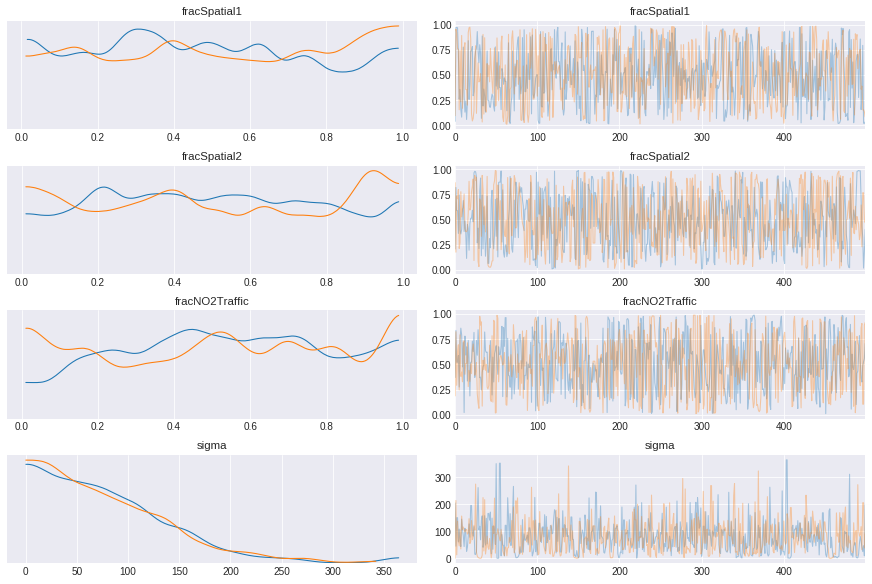

In [6]:
pm.traceplot(trace)

In [7]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
fracSpatial1,0.50,0.28,0.05,0.97,0.01,0.01,821.0,807.0,775.0,548.0,1.00
fracSpatial2,0.50,0.28,0.07,0.98,0.01,0.01,816.0,782.0,771.0,479.0,1.01
fracNO2Traffic,0.52,0.28,0.08,0.99,0.01,0.01,918.0,843.0,896.0,543.0,1.01
sigma,81.78,64.11,0.04,194.42,2.13,1.52,905.0,891.0,499.0,308.0,1.00
